In [10]:
# https://jessesw.com/XG-Boost/
# https://www.dataiku.com/learn/guide/code/python/advanced-xgboost-tuning.html Using Sparce Matrix
import xgboost as xgb
import pandas as pd
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score


# train data
data = pd.read_csv('train/train_small.csv', header = 0)
data = data.fillna(0)
print(data.info())
X = data.drop(['order_id','cancel', 'dow'], axis=1)
y = data['cancel']

folds = 5
kf = KFold(folds, shuffle = True, random_state = 42)

#for train_index, test_index in kf.split(X):
#    print("TRAIN:", train_index, "TEST:", test_index)
#    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
#    y_train, y_val = y[train_index], y[test_index]


train_indeces, val_indeces = next(kf.split(y))

X_train, y_train = X.iloc[train_indeces], y[train_indeces]
X_val, y_val = X.iloc[val_indeces], y[val_indeces]

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
# del(data, X, y)

# test data
test_data = pd.read_csv('test/test-20-29-jun.csv', header = 0)
X_test = test_data.drop(['order_id','cancel', 'dow'], axis=1)
y_test = test_data['cancel']
dtest = xgb.DMatrix(X_test, label=y_test)
#del(test_data, X_test, y_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51761 entries, 0 to 51760
Data columns (total 35 columns):
order_id                             51761 non-null int64
total_cents                          51761 non-null int64
subtotal_cents                       51761 non-null int64
discount                             51761 non-null int64
discount_prc                         51761 non-null float64
cash_flg                             51761 non-null int64
auto_flg                             51761 non-null int64
dow                                  51761 non-null int64
hot                                  51761 non-null int64
additionals_num                      51761 non-null int64
day_slot_flg                         51761 non-null int64
has_comment                          51761 non-null int64
subscription_flg                     51761 non-null int64
lat                                  51761 non-null float64
lng                                  51761 non-null float64
creation_start_

# Grid Search

In [25]:
cv_params = {
    'max_depth': [6],
    'min_child_weight': [1,3]
}
# ind_params = {'objective': 'binary:logistic', 'n_estimators': 100}
ind_params = {
    'learning_rate': 0.2,
    'n_estimators': 1000,
    'seed':0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic'}


optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), cv_params, scoring = 'roc_auc', cv = 3, n_jobs = 1) 
# Optimize for accuracy since that is the metric used in the Adult Data Set notation

In [26]:
%%time
optimized_GBM.fit(X, y)

CPU times: user 9min 12s, sys: 17.1 s, total: 9min 29s
Wall time: 2min 51s


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_child_weight': [1, 3], 'max_depth': [6]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [27]:
optimized_GBM.grid_scores_

[mean: 0.74567, std: 0.03257, params: {'min_child_weight': 1, 'max_depth': 6},
 mean: 0.74677, std: 0.03692, params: {'min_child_weight': 3, 'max_depth': 6}]

In [28]:
y_pred = optimized_GBM.predict(X_test)
print(roc_auc_score(y_test, y_pred))

0.743831966748


# Early Stopping

In [14]:
# specify parameters via map
param = {'max_depth':5, 'eta':0.2, 'silent':0, 'objective':'binary:logistic' }
param['eval_metric'] = 'auc'
evallist  = [(dtrain,'train'), (dval,'eval')]
num_round = 300

bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)
# make prediction
preds = bst.predict(dtest)

print(roc_auc_score(y_test, preds))

[0]	train-auc:0.769996	eval-auc:0.77128
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.786751	eval-auc:0.786452
[2]	train-auc:0.790913	eval-auc:0.787096
[3]	train-auc:0.79555	eval-auc:0.792341
[4]	train-auc:0.799514	eval-auc:0.795705
[5]	train-auc:0.802876	eval-auc:0.796253
[6]	train-auc:0.806986	eval-auc:0.798101
[7]	train-auc:0.808066	eval-auc:0.798789
[8]	train-auc:0.810802	eval-auc:0.801053
[9]	train-auc:0.812912	eval-auc:0.802281
[10]	train-auc:0.814638	eval-auc:0.803011
[11]	train-auc:0.816057	eval-auc:0.803993
[12]	train-auc:0.818078	eval-auc:0.804953
[13]	train-auc:0.819539	eval-auc:0.805835
[14]	train-auc:0.820471	eval-auc:0.806724
[15]	train-auc:0.822636	eval-auc:0.807712
[16]	train-auc:0.824009	eval-auc:0.807739
[17]	train-auc:0.82517	eval-auc:0.808164
[18]	train-auc:0.82629	eval-auc:0.809013
[19]	train-auc:0.82743	eval-auc:0.810138
[20]	train-auc:0.828357	eval-auc:0

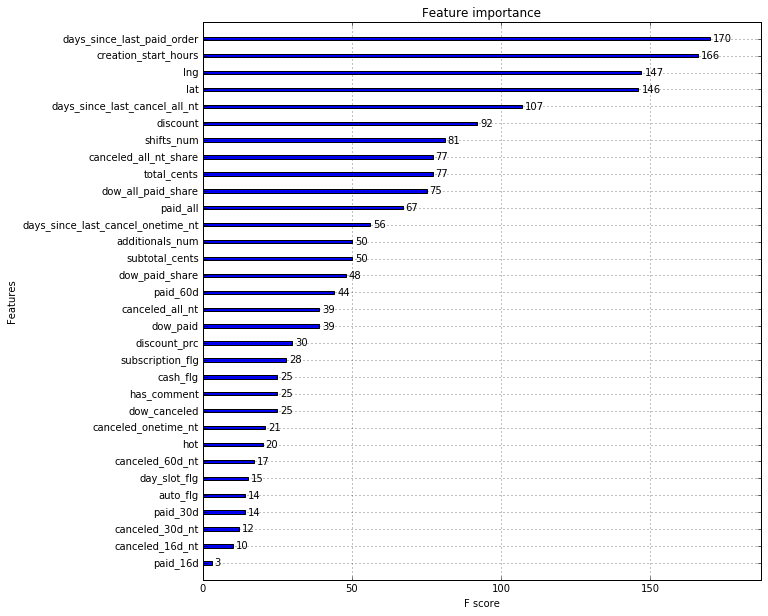

In [38]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

width = 20
height = 20
#plt.figure(figsize=(width, height))
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(bst, ax=ax)
